# Querying a JointDb: Visualizing Chromatin Structure and Epigenetic Signal in T Cells

This notebook demonstrates how to use a `JointDb` HDF5 database created with `jointly-hic` to explore low-dimensional Hi-C embeddings and their relationship to epigenomic features such as ChIP-seq signal tracks.

The data consists of Hi-C contact matrices and ChIP-seq experiments for **CD4+** and **CD8+ T cells** from ENCODE, which have been jointly embedded and integrated into a structured database using `jointly-hic`.

## What You’ll Learn

- How to connect to a `JointDb` and inspect metadata
- How to query per-sample and full-cohort Hi-C embeddings (PCA/UMAP)
- How to visualize clustering results across biosamples
- How to overlay ChIP-seq signal intensity onto UMAP embeddings
- How to explore the genome browser-style relationship between:
  - PC-1 values (representing compartment structure)
  - ChIP-seq signals (e.g., H3K9me3 enrichment)
  - Genomic location (e.g., `chr1`)

## Key Concepts

- **Hi-C embeddings** capture large-scale 3D chromatin compartment structure.
- **UMAP and PCA** provide interpretable 2D projections for cluster visualization.
- **ChIP-seq overlays** allow direct correlation between structural chromatin states and histone modifications.
- **Per-chromosome plots** can reveal relationships between compartment scores and histone marks.

## Requirements

This notebook assumes you have already:
1. Created a `JointDb` `.h5` file using `jointly hdf5db`
2. Prepared valid experiment and track metadata (YAML)
3. Included signal tracks in bigWig format, referenced via ENCODE accessions

## Output

The notebook generates several useful figures:
- PCA and UMAP plots colored by clustering or chromosome
- ChIP-seq signal overlays for multiple histone marks
- Browser-style genomic line plots for PC-1 and histone signal (e.g., H3K9me3)
- Scatterplots illustrating anti-correlation between chromatin structure and repression

These visualizations provide an interactive and scalable way to interpret 3D genome structure in the context of epigenomic regulation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datashader as ds
import seaborn as sns
from datashader.mpl_ext import dsshow

from jointly_hic.hdf5db.hdf5db import JointDb

# Prepare for saving PDF files
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["svg.fonttype"] = "none"

In [2]:
# Connect a JointDb wrapper to the database
JOINTDB_FILE = "./data/t-cell-jointdb.h5"
db = JointDb(JOINTDB_FILE)
db

JointDb(file='./data/t-cell-jointdb.h5', bins=38614, experiments=10, tracks=68)

In [3]:
# View experiment metadata
db.experiment_metadata

,accession,biosample,biosample_summary
0,ENCFF009ONH,"CD8-positive, alpha-beta T cell","Homo sapiens CD8-positive, alpha-beta T cell m..."
1,ENCFF044TCQ,"naive thymus-derived CD4-positive, alpha-beta ...",Homo sapiens naive thymus-derived CD4-positive...
2,ENCFF355VJW,"activated CD4-positive, alpha-beta T cell","Homo sapiens activated CD4-positive, alpha-bet..."
3,ENCFF442IGJ,"CD4-positive, alpha-beta memory T cell","Homo sapiens CD4-positive, alpha-beta memory T..."
4,ENCFF493SFI,"activated CD8-positive, alpha-beta T cell","Homo sapiens activated CD8-positive, alpha-bet..."
5,ENCFF520GFL,"naive thymus-derived CD4-positive, alpha-beta ...",Homo sapiens naive thymus-derived CD4-positive...
6,ENCFF571GTF,"activated naive CD4-positive, alpha-beta T cell","Homo sapiens activated naive CD4-positive, alp..."
7,ENCFF958DWQ,"CD4-positive, alpha-beta T cell","Homo sapiens CD4-positive, alpha-beta T cell m..."
8,ENCFF962EDB,"activated CD4-positive, alpha-beta T cell","Homo sapiens activated CD4-positive, alpha-bet..."
9,ENCFF980NXK,"activated CD4-positive, alpha-beta memory T cell","Homo sapiens activated CD4-positive, alpha-bet..."


In [4]:
# View track metadata
db.track_metadata

,accession,assay,experiment,biosample
0,ENCFF014CKV,H3K9me3,ENCSR815PSO,"CD8-positive, alpha-beta T cell"
1,ENCFF020CWJ,H3K27me3,ENCSR103GGR,"CD8-positive, alpha-beta T cell"
2,ENCFF034CTK,H3K4me1,ENCSR971QHH,"CD4-positive, alpha-beta T cell"
3,ENCFF061JOB,H3K4me1,ENCSR887ESB,"CD4-positive, alpha-beta memory T cell"
4,ENCFF078XQO,H3K4me3,ENCSR161XBV,"naive thymus-derived CD4-positive, alpha-beta ..."
...,...,...,...,...
63,ENCFF959DIS,H3K4me1,ENCSR660WQO,"CD4-positive, alpha-beta memory T cell"
64,ENCFF966FLQ,H3K27ac,ENCSR007HLH,"CD8-positive, alpha-beta T cell"
65,ENCFF975SNY,H3K4me3,ENCSR457FQI,"CD4-positive, alpha-beta memory T cell"
66,ENCFF979VKE,H3K36me3,ENCSR681OSD,"CD8-positive, alpha-beta T cell"


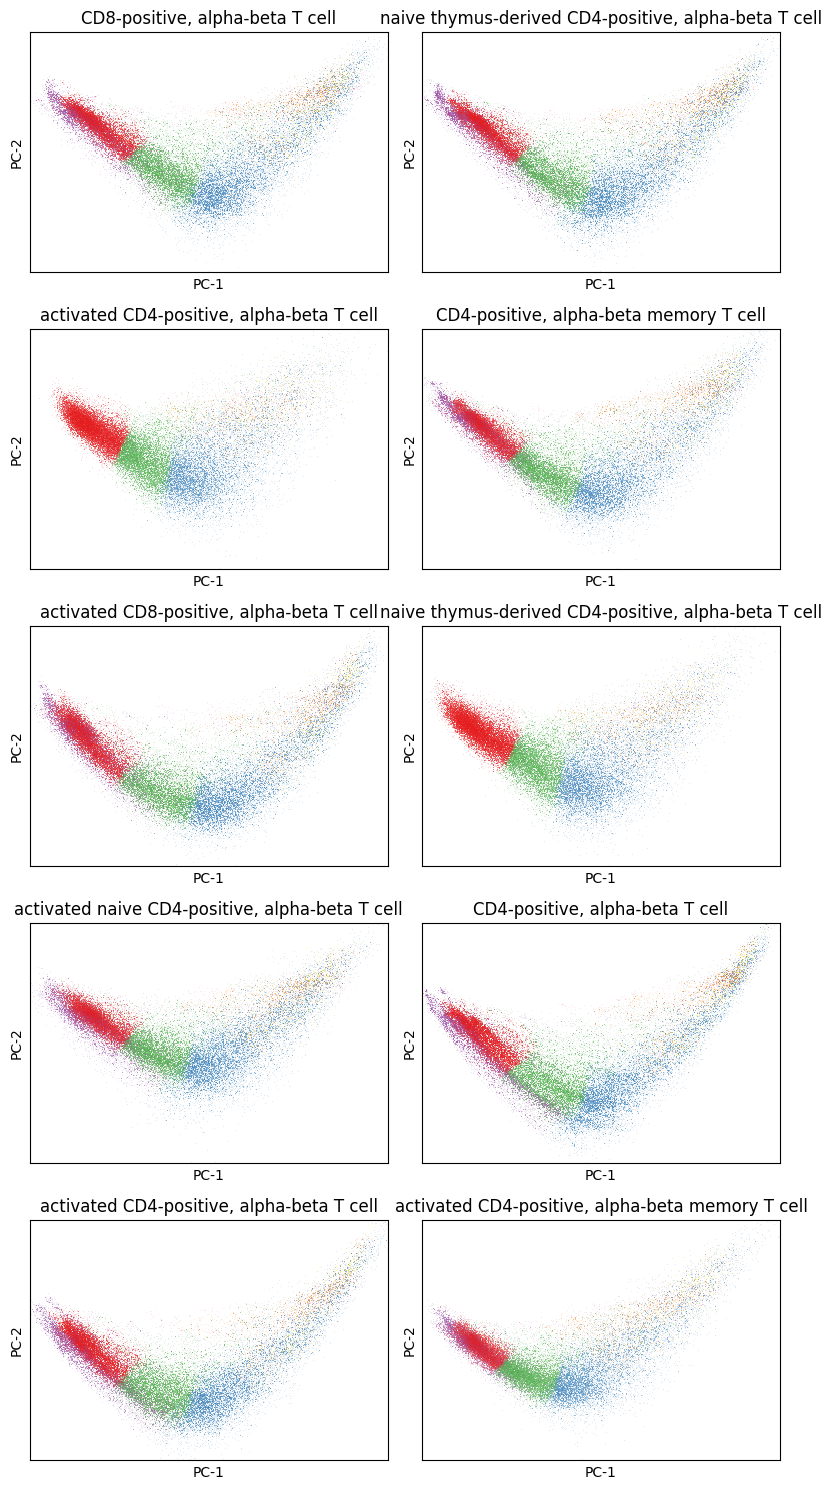

In [5]:
# Plot PCA embeddings for each sample, colored by leiden_0_5_n500 clusters
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(8, 15))
axes = axes.flatten()

for i, row in db.experiment_metadata.iterrows():
    acc = row["accession"]
    biosample = row["biosample"]
    ax = axes[i]

    # Query DB for data for this accession & embeddings
    embeddings = db.get_embeddings(
        embeddings=["PCA1", "PCA2", "leiden_0_3_n500"],
        accessions=[acc],
        drop_bad_bins=True,
    )

    # Convert "leiden_0_3_n500" to category & store as "cluster"
    embeddings["cluster"] = embeddings["leiden_0_3_n500"].astype("category")
    im = dsshow(
        embeddings,
        ds.Point("PCA1", "PCA2"),
        aggregator=ds.count_cat("cluster"),
        aspect="auto",
        ax=ax,
    )
    ax.set_title(biosample)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("PC-1")
    ax.set_ylabel("PC-2")


plt.savefig("PCA-embeddings-clustered.pdf", dpi=300)
plt.tight_layout()
plt.show()

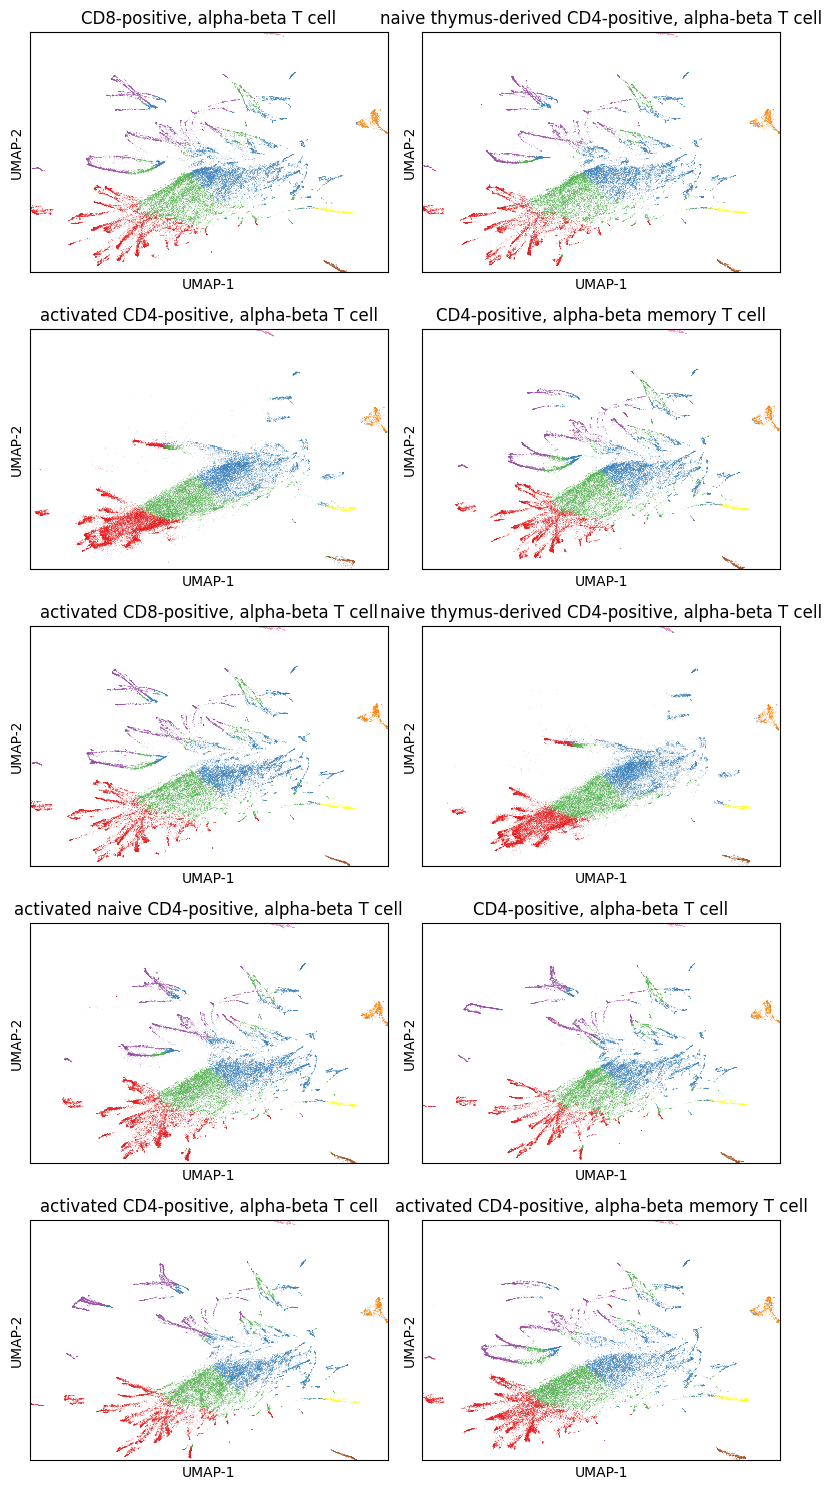

In [6]:
# Plot UMAP embeddings for each sample, colored by leiden_0_5_n500 clusters
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(8, 15))
axes = axes.flatten()

for i, row in db.experiment_metadata.iterrows():
    acc = row["accession"]
    biosample = row["biosample"]
    ax = axes[i]

    # Query DB for data for this accession & embeddings
    embeddings = db.get_embeddings(
        embeddings=["umap1_n100", "umap2_n100", "leiden_0_3_n500"],
        accessions=[acc],
        drop_bad_bins=True,
    )

    # Convert "leiden_0_3_n500" to category & store as "cluster"
    embeddings["cluster"] = embeddings["leiden_0_3_n500"].astype("category")
    im = dsshow(
        embeddings,
        ds.Point("umap1_n100", "umap2_n100"),
        aggregator=ds.count_cat("cluster"),
        aspect="auto",
        ax=ax,
    )
    ax.set_title(biosample)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")

plt.savefig("UMAP-embeddings-clustered.pdf", dpi=300)
plt.tight_layout()
plt.show()

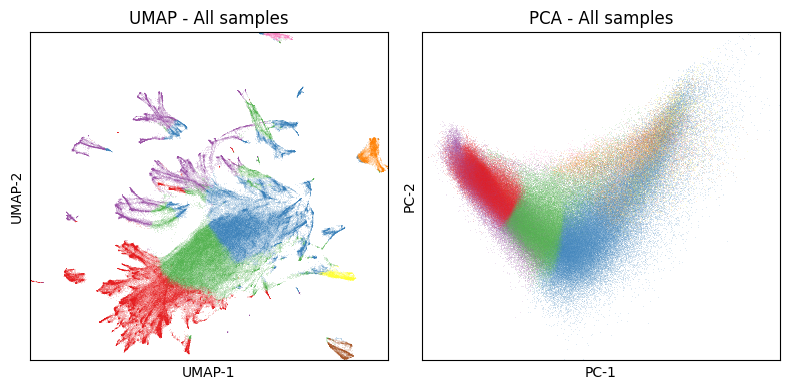

In [7]:
# Plot UMAP & PCA for all samples in one plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

# Query DB for data for this accession & embeddings
embeddings = db.get_embeddings(
    embeddings=["umap1_n100", "umap2_n100", "PCA1", "PCA2", "leiden_0_3_n500"],
    drop_bad_bins=True,
)

# Convert "leiden_0_3_n500" to category & store as "cluster"
embeddings["cluster"] = embeddings["leiden_0_3_n500"].astype("category")

# Plot UMAP
im = dsshow(
    embeddings,
    ds.Point("umap1_n100", "umap2_n100"),
    aggregator=ds.count_cat("cluster"),
    aspect="auto",
    ax=axes[0],
)
axes[0].set_title("UMAP - All samples")
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_xlabel("UMAP-1")
axes[0].set_ylabel("UMAP-2")

# Plot PCA
im = dsshow(
    embeddings,
    ds.Point("PCA1", "PCA2"),
    aggregator=ds.count_cat("cluster"),
    aspect="auto",
    ax=axes[1],
)
axes[1].set_title("PCA - All samples")
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_xlabel("PC-1")
axes[1].set_ylabel("PC-2")

plt.savefig("UMAP-PCA-all-samples.pdf", dpi=300)
plt.tight_layout()
plt.show()

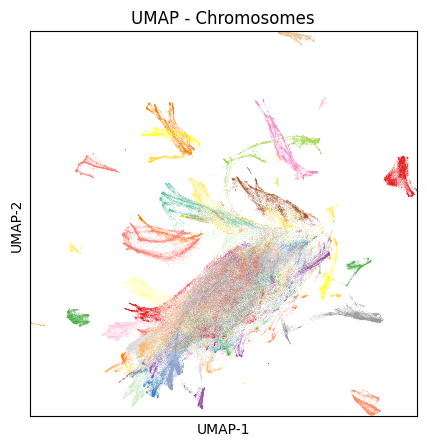

In [8]:
# The "stranded" aspect of the UMAP might be expalained by chromosome separation
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

# Filter to numerical chroms 1-22
embeddings = embeddings[
    embeddings["chrom"].isin([f"chr{i+1}" for i in range(22)])
].copy()

# Convert "chrom" to category & store as "chrom_cat"
embeddings["chrom_cat"] = embeddings["chrom"].astype("category")

# Plot UMAP
im = dsshow(
    embeddings,
    ds.Point("umap1_n100", "umap2_n100"),
    aggregator=ds.count_cat("chrom_cat"),
    aspect="auto",
    ax=axis,
)
axis.set_title("UMAP - Chromosomes")
axis.set_xticks([])
axis.set_yticks([])
axis.set_xlabel("UMAP-1")
axis.set_ylabel("UMAP-2")
plt.show()

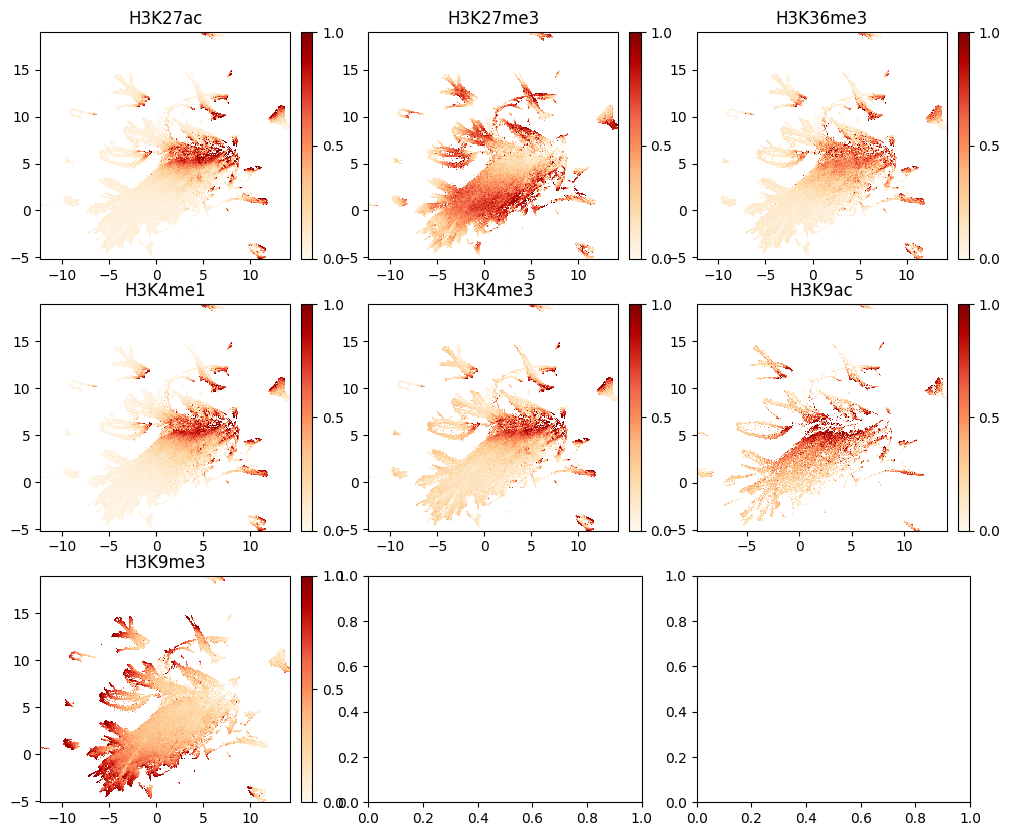

In [9]:
# Plot ChIP-seq overlays
# Join ChIP-seq tracks to Hi-C embeddings on "biosample" and scale signal (clip & scale for each track)
# Plot overlays for all ChIP-seq targets


def scale_signal(df) -> pd.DataFrame:
    """
    Scale the signal data in a DataFrame by clipping outliers at the 0.05 and 0.95 quantiles,
    then normalizing to the [0, 1] range.

    Args:
        df (pd.DataFrame): DataFrame containing signal data to be scaled.

    Returns:
        pd.DataFrame: DataFrame with scaled signal data.
    """

    def clip_and_scale(x):
        lower = x.quantile(0.05)
        upper = x.quantile(0.95)
        x_clipped = x.clip(lower=lower, upper=upper)
        return (x_clipped - lower) / (upper - lower)

    df["signal"] = df.groupby("bw_accession")["signal"].transform(clip_and_scale)
    return df


# List of ChIP-seq targets
targets = db.track_metadata.assay.unique()
targets.sort()

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 10))
axes = axes.flatten()

# Iterate over assays and axes
for ax, target in zip(axes, targets):
    # Gather ChIP-seq data for the specified target and apply the scaler
    umap_overlay = db.get_track_overlay(
        target, ["umap1_n100", "umap2_n100"], drop_bad_bins=True, scaler=scale_signal
    )

    # Plot the data using Datashader
    im = dsshow(
        umap_overlay,
        ds.Point("umap1_n100", "umap2_n100"),
        aggregator=ds.mean("signal"),
        aspect="auto",
        cmap="OrRd",
        ax=ax,
    )

    # Place a colorbar for each subplot
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_ticks([0, 0.5, 1])

    ax.set_title(target)
    axis.set_xticks([])
    axis.set_yticks([])

plt.savefig("ChIP-UMAP-overlays.pdf", dpi=300)
plt.show()

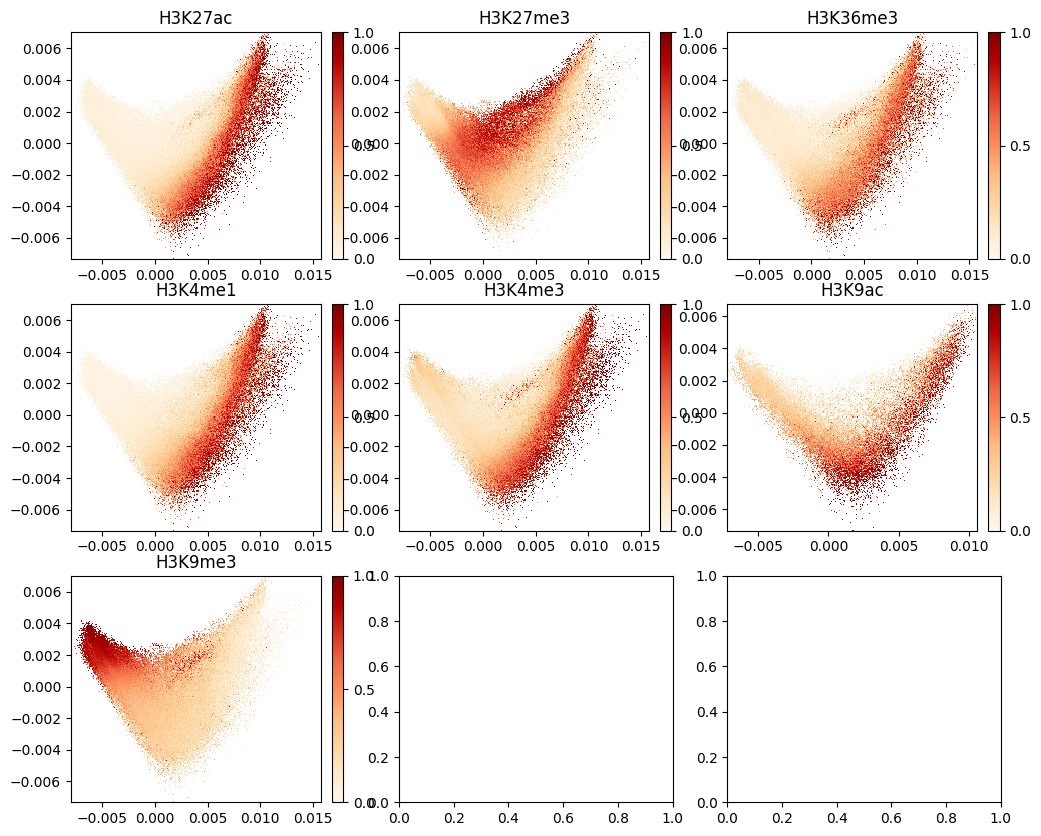

In [10]:
# Plot ChIP-seq overlays
# Join ChIP-seq tracks to Hi-C embeddings on "biosample" and scale signal (clip & scale for each track)
# Plot overlays for all ChIP-seq targets

# List of ChIP-seq targets
targets = db.track_metadata.assay.unique()
targets.sort()

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 10))
axes = axes.flatten()

# Iterate over assays and axes
for ax, target in zip(axes, targets):
    # Gather ChIP-seq data for the specified target and apply the scaler
    overlay = db.get_track_overlay(
        target, ["PCA1", "PCA2"], drop_bad_bins=True, scaler=scale_signal
    )

    # Plot the data using Datashader
    im = dsshow(
        overlay,
        ds.Point("PCA1", "PCA2"),
        aggregator=ds.mean("signal"),
        aspect="auto",
        cmap="OrRd",
        ax=ax,
    )

    # Place a colorbar for each subplot
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_ticks([0, 0.5, 1])

    ax.set_title(target)
    axis.set_xticks([])
    axis.set_yticks([])

plt.savefig("ChIP-PCA-overlays.pdf", dpi=300)
plt.show()

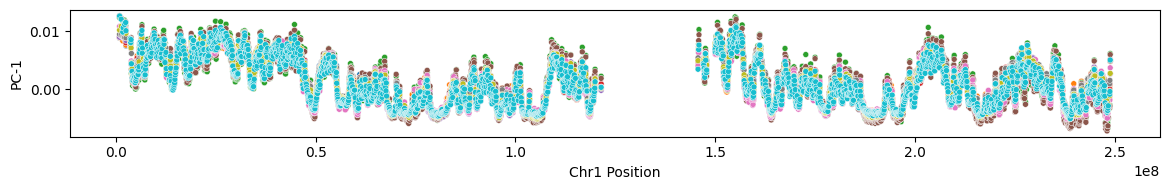

In [11]:
# Plot "Genome Browser" tracks for chr1
embeddings = db.get_embeddings(embeddings=["PCA1"], drop_bad_bins=False)
embeddings = embeddings[embeddings["chrom"] == "chr1"].copy()

fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(12, 2))
sns.scatterplot(
    data=embeddings, x="start", y="PCA1", size=1, hue="accession", ax=axis, legend=None
)

axis.set_xlabel("Chr1 Position")
axis.set_ylabel("PC-1")

plt.savefig("PC1-chr1-track-view.pdf", dpi=300)
plt.tight_layout()
plt.show()

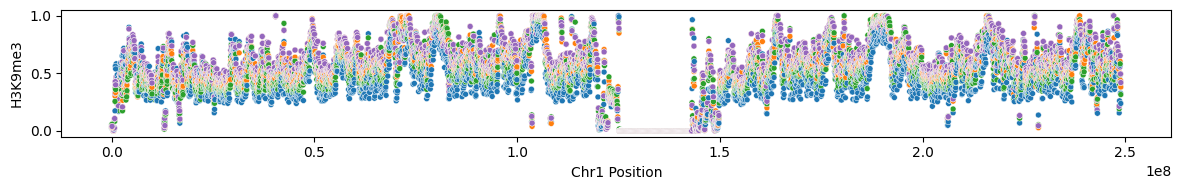

In [12]:
# Plot H3K9me3 signal along the same view
chip_signal = db.get_track_overlay(
    "H3K9me3", ["PCA1"], drop_bad_bins=False, scaler=scale_signal
)

# Merge bin information
chip_signal = chip_signal.merge(db.bins)

# Filter to chr1
chip_signal = chip_signal[chip_signal["chrom"] == "chr1"]

fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(12, 2))
sns.scatterplot(
    data=chip_signal,
    x="start",
    y="signal",
    size=1,
    hue="accession",
    ax=axis,
    legend=None,
)

axis.set_xlabel("Chr1 Position")
axis.set_ylabel("H3K9me3")

plt.savefig("H3K9me3-chr1-track-view.pdf", dpi=300)
plt.tight_layout()
plt.show()

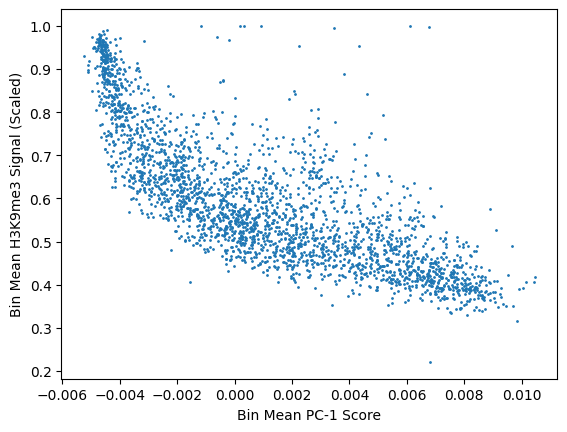

In [13]:
# Plot inverse relationship between PC-1 and H3K9me3 signal in chr1
plt.scatter(
    embeddings[["start", "PCA1"]].groupby("start").mean()["PCA1"],
    chip_signal[["start", "signal"]].groupby("start").mean()["signal"],
    s=1,
)

plt.xlabel("Bin Mean PC-1 Score")
plt.ylabel("Bin Mean H3K9me3 Signal (Scaled)")
plt.savefig("PC1-vs-H3K9me3-signal-chr1.pdf", dpi=300)
plt.show()